# Spaceship Titanic: анализ, обучение моделей

## Загрузка модулей

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Загрузка данных

In [2]:
df_train = pd.read_csv('C:\\Users\\Zver\\Desktop\\uni\\наука о данных\\train.csv')
df_test = pd.read_csv('C:\\Users\\Zver\\Desktop\\uni\\наука о данных\\test.csv')

## Анализ данных

Размер train: (8693, 14)
Размер test: (4277, 13)

Первые строки train:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


<Figure size 1200x800 with 0 Axes>

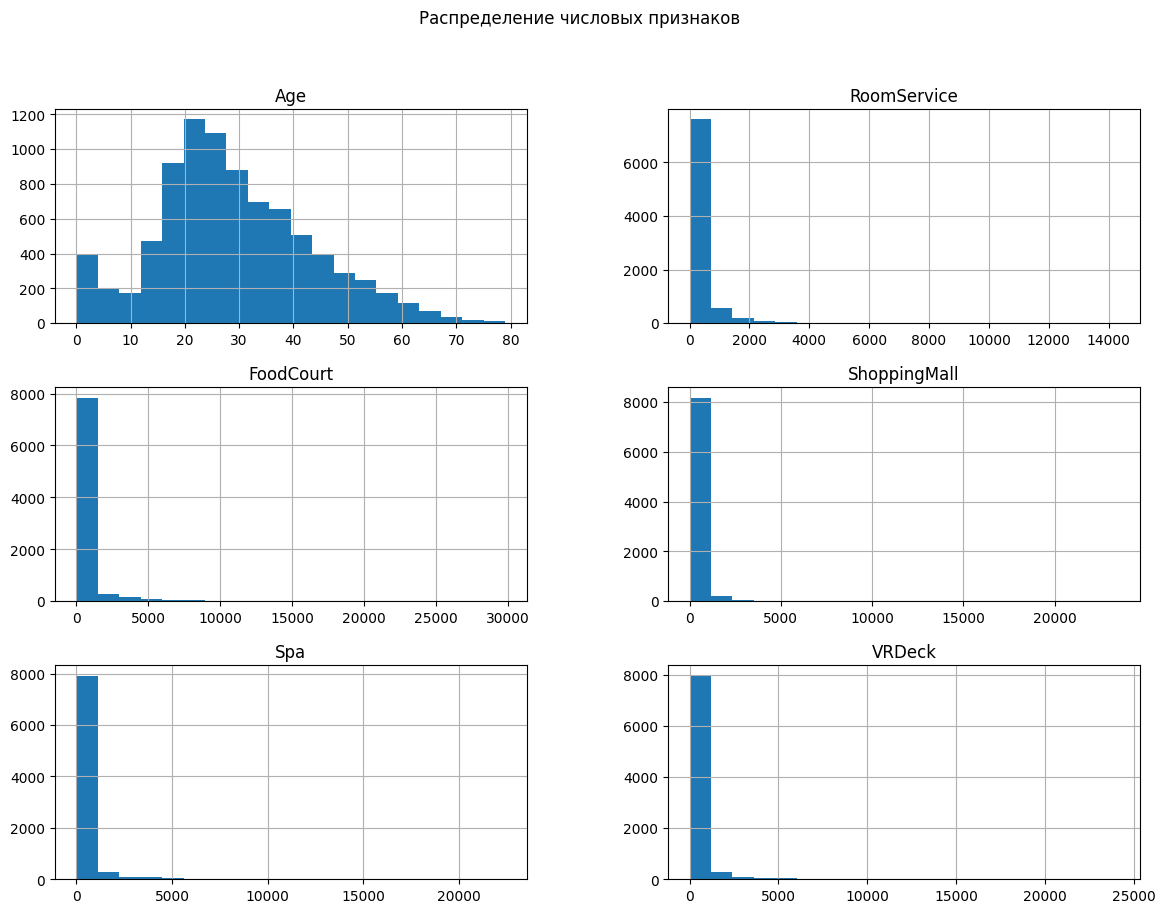

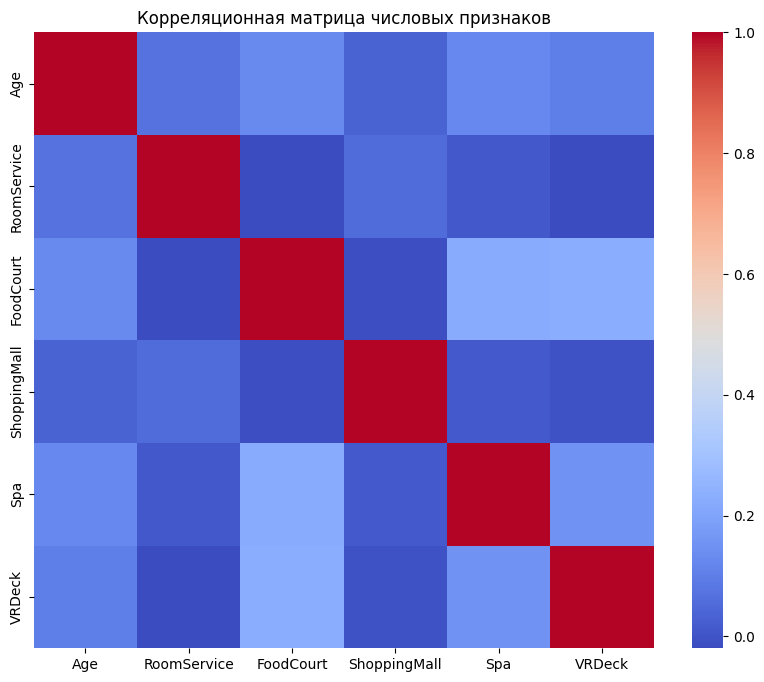

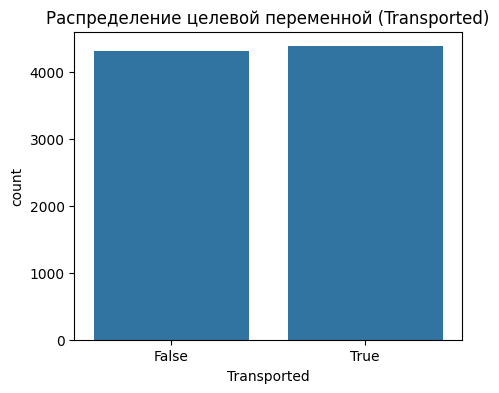

In [3]:
# Первичный анализ данных
print('Размер train:', df_train.shape)
print('Размер test:', df_test.shape)
print('\nПервые строки train:')
display(df_train.head())


# Визуализация распределения числовых признаков
num_cols = df_train.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 8))
df_train[num_cols].hist(bins=20, figsize=(14,10))
plt.suptitle('Распределение числовых признаков')
plt.show()


# Корреляционная матрица
plt.figure(figsize=(10,8))
sns.heatmap(df_train[num_cols].corr(), cmap='coolwarm', annot=False)
plt.title('Корреляционная матрица числовых признаков')
plt.show()


# Распределение целевой переменной
plt.figure(figsize=(5,4))
sns.countplot(x='Transported', data=df_train)
plt.title('Распределение целевой переменной (Transported)')
plt.show()

In [4]:
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

<Axes: xlabel='VIP', ylabel='Transported'>

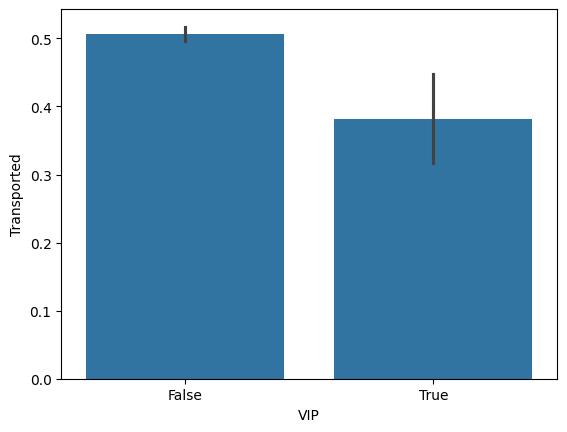

In [19]:
sns.barplot(x='VIP', y='Transported', data=df_train)

Пассажиры без VIP транспортированы чаще

<Axes: xlabel='HomePlanet', ylabel='Transported'>

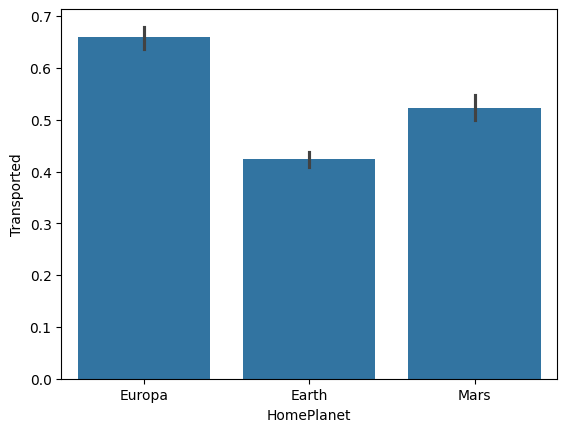

In [6]:
sns.barplot(x='HomePlanet', y='Transported', data=df_train)

Пассажиры с Земли с меньшей вероятностью были транспортированы, а с Европы наоборот с большей

<Axes: xlabel='CryoSleep', ylabel='Transported'>

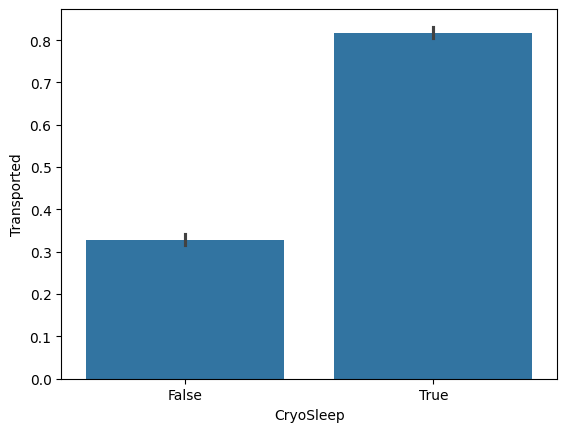

In [7]:
sns.barplot(x='CryoSleep', y='Transported', data=df_train)

Пассажиры в криосне имели больше шансов на транспортировку

<Axes: xlabel='Destination', ylabel='Transported'>

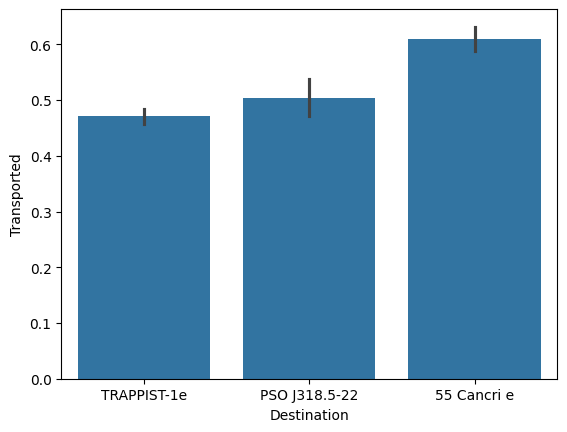

In [8]:
sns.barplot(x='Destination', y='Transported', data=df_train)

Пассажиры с наиболее популярным местом прибытия реже транспортировались по сравнению с теми, чье место прибытия 55 Cancri e

<Axes: xlabel='HomePlanet', ylabel='Age'>

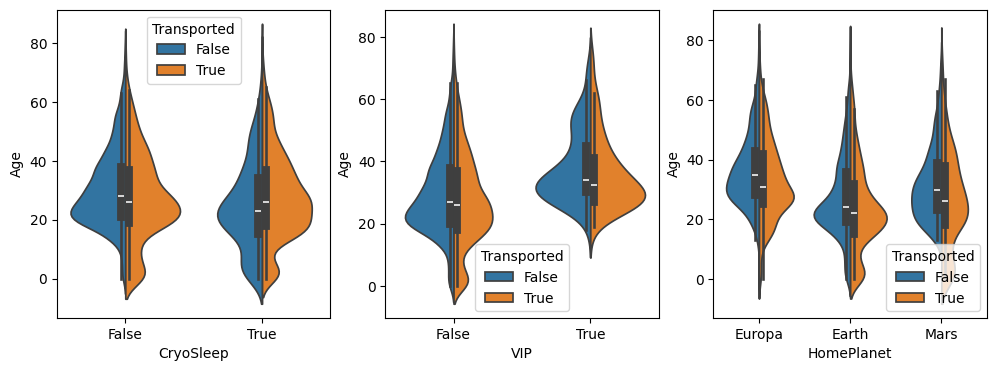

In [9]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.violinplot(x="CryoSleep", y="Age", hue="Transported", data=df_train, split=True, ax=ax1)
sns.violinplot(x="VIP", y="Age", hue="Transported", data=df_train, split=True, ax=ax2)
sns.violinplot(x="HomePlanet", y="Age", hue="Transported", data=df_train, split=True, ax=ax3)

Не похоже, чтобы возраст влиял на транспортировку

<Axes: xlabel='count', ylabel='mean'>

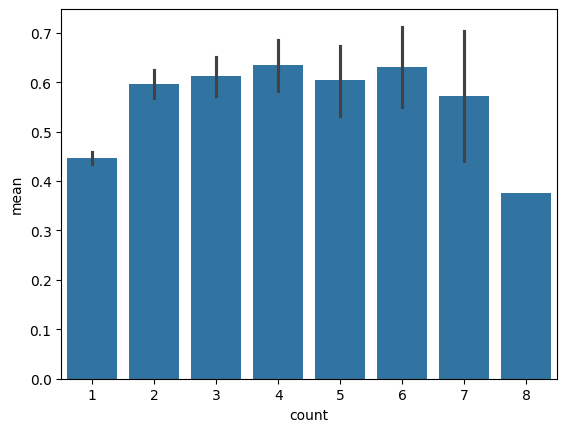

In [10]:
cabins = df_train['Cabin'].value_counts()
sorted_by_cabin = df_train.groupby('Cabin')['Transported'].agg(['count', 'mean']).sort_values(by='count')

sns.barplot(data=sorted_by_cabin, x="count", y="mean")

Группы средних размеров транспортировались чаще

## Объединение и выделение новых признаков

In [11]:
# Объединим для одинаковой обработки
all_data = pd.concat([df_train.drop(columns=['Transported']), df_test], axis=0, ignore_index=True)

# Фичи
all_data[['Deck','Cabin_num','Side']] = all_data['Cabin'].fillna('Unknown/0/Unknown').str.split('/', expand=True)
money_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
all_data['TotalSpending'] = all_data[money_cols].fillna(0).sum(axis=1)

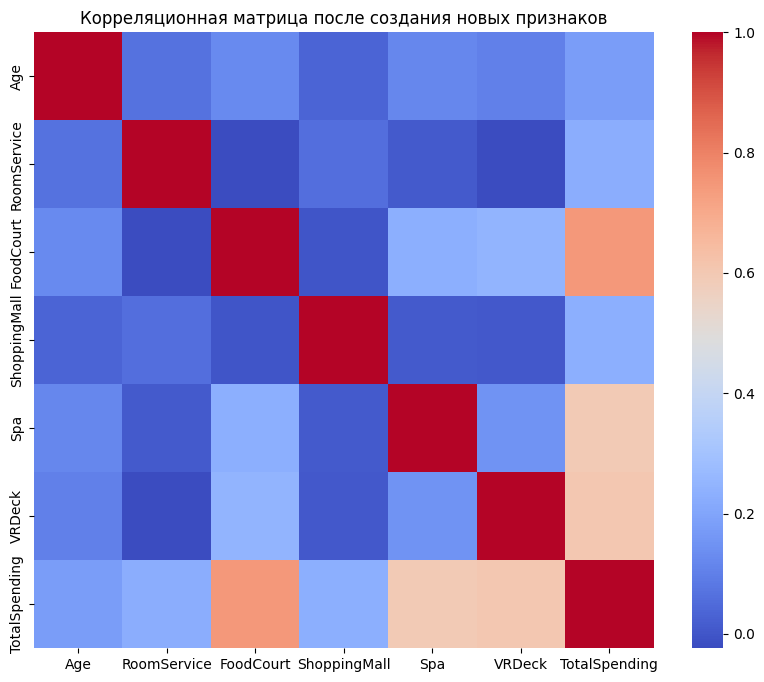

In [12]:
# Корреляция после создания новых признаков
num_after = all_data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10,8))
sns.heatmap(all_data[num_after].corr(), cmap='coolwarm', annot=False)
plt.title('Корреляционная матрица после создания новых признаков')
plt.show()

## Заполнение пропусков и кодирование категорий

In [13]:
# Если CryoSleep == True, то траты должны быть равны 0
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
all_data.loc[all_data['CryoSleep'] == True, spend_cols] = 0

# Для остальных пропусков в тратах заменим NaN на медиану по каждому признаку
for col in spend_cols:
    all_data[col] = all_data[col].fillna(all_data[col].median())

# Заполним пропуски в Age медианой по HomePlanet (если есть связь)
if 'HomePlanet' in all_data.columns:
    all_data['Age'] = all_data.groupby('HomePlanet')['Age'].transform(
        lambda x: x.fillna(x.median())
    )
all_data['Age'] = all_data['Age'].fillna(all_data['Age'].median())

# Категориальные признаки: заполняем модой по HomePlanet, если возможно
cat_cols = ['HomePlanet', 'Destination', 'Deck', 'Side']
for col in cat_cols:
    if col in all_data.columns:
        all_data[col] = all_data.groupby('HomePlanet')[col].transform(
            lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
        )
    all_data[col] = all_data[col].fillna('Unknown')

# Булевы признаки
all_data['CryoSleep'] = all_data['CryoSleep'].fillna(False)
all_data['VIP'] = all_data['VIP'].fillna(False)


# Проверим, что пропусков больше нет
print('Оставшиеся пропуски после заполнения:')
print(all_data.isna().sum()[all_data.isna().sum() > 0])

Оставшиеся пропуски после заполнения:
Cabin    299
Name     294
dtype: int64


C:\Users\Zver\AppData\Local\Temp\ipykernel_25416\3894687537.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_data['CryoSleep'] = all_data['CryoSleep'].fillna(False)
C:\Users\Zver\AppData\Local\Temp\ipykernel_25416\3894687537.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_data['VIP'] = all_data['VIP'].fillna(False)


## Подготовка к обучению

In [14]:
for col in ['HomePlanet','Destination','Deck','Side']:
    all_data[col] = LabelEncoder().fit_transform(all_data[col].astype(str))

X = all_data.iloc[:len(df_train)].drop(columns=['PassengerId','Name','Cabin'])
X_test_final = all_data.iloc[len(df_train):].drop(columns=['PassengerId','Name','Cabin'])
y = df_train['Transported'].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_final)

## Обучение моделей

In [15]:
# Linear Regression
lin = LinearRegression().fit(X_scaled, y)
y_pred_lin = (np.clip(lin.predict(X_scaled),0,1) >= 0.5).astype(int)
print('Linear Regression Accuracy:', accuracy_score(y, y_pred_lin))

# PCA
pca = PCA(n_components=5, random_state=42)
Xp = pca.fit_transform(X_scaled)
Xp_test = pca.transform(X_test_scaled)
lin_pca = LinearRegression().fit(Xp, y)
y_pred_pca = (np.clip(lin_pca.predict(Xp),0,1) >= 0.5).astype(int)
print('PCA Accuracy:', accuracy_score(y, y_pred_pca))

# Decision Tree
tree = DecisionTreeClassifier(max_depth=6, random_state=42).fit(X, y)
print('Decision Tree Accuracy:', accuracy_score(y, tree.predict(X)))

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42).fit(X, y)
print('Random Forest Accuracy:', accuracy_score(y, rf.predict(X)))

Linear Regression Accuracy: 0.7647532497411711
PCA Accuracy: 0.7181640400322098
Decision Tree Accuracy: 0.8029448981939492
Random Forest Accuracy: 0.9994248245714943


## Визуализация важности признаков

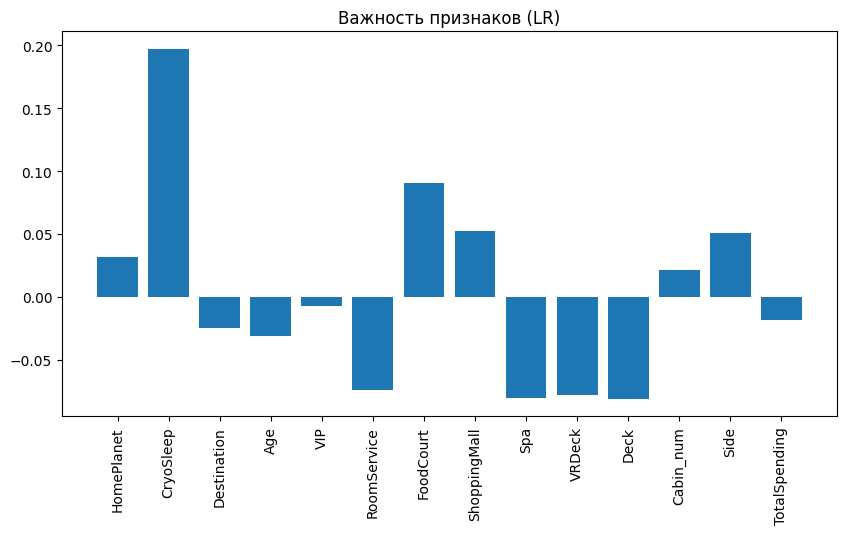

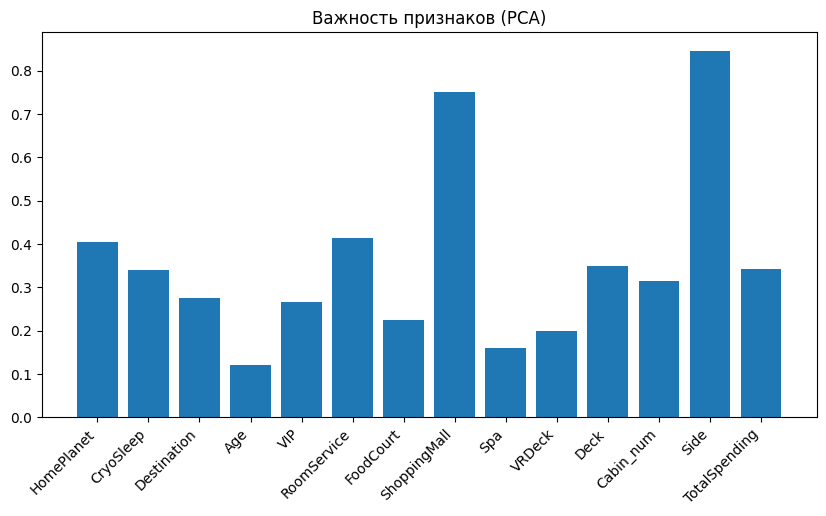

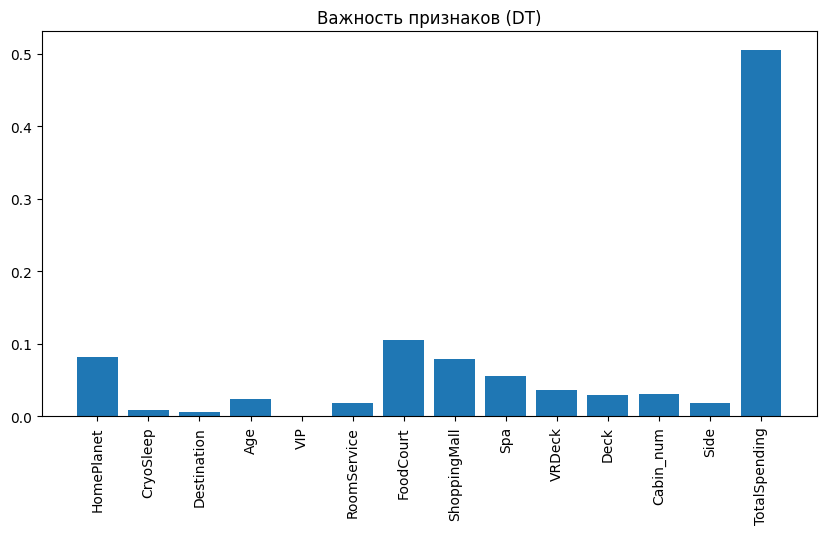

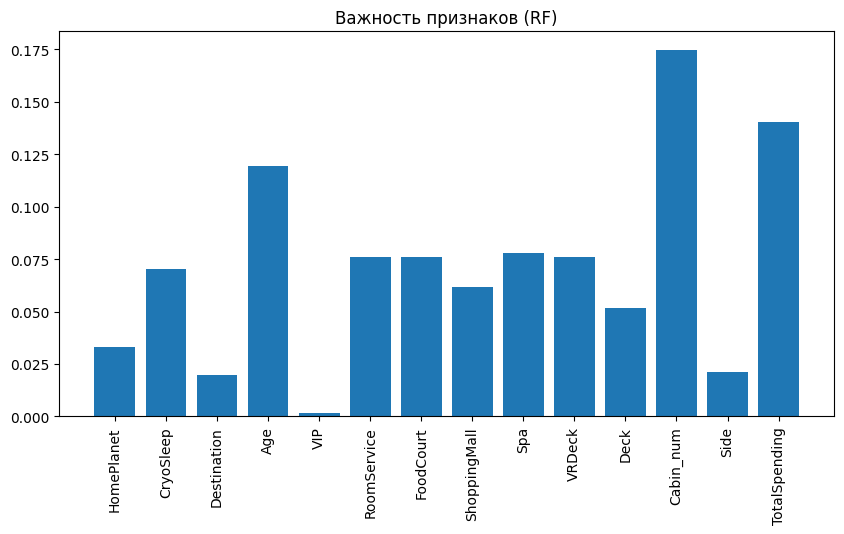

In [16]:
feature_names = X.columns

plt.figure(figsize=(10,5))
plt.bar(feature_names, lin.coef_)
plt.xticks(rotation=90)
plt.title('Важность признаков (LR)')
plt.show()

loadings = pca.components_
importance = (loadings**2).sum(axis=0)
importance_df = pd.Series(importance, index=X.columns)
plt.figure(figsize=(10,5))
plt.bar(importance_df.index, importance_df.values)
plt.xticks(rotation=45, ha='right')
plt.title('Важность признаков (PCA)')
plt.show()

plt.figure(figsize=(10,5))
plt.bar(feature_names, tree.feature_importances_)
plt.xticks(rotation=90)
plt.title('Важность признаков (DT)')
plt.show()

plt.figure(figsize=(10,5))
plt.bar(feature_names, rf.feature_importances_)
plt.xticks(rotation=90)
plt.title('Важность признаков (RF)')
plt.show()

## Создание финального файла

In [17]:
preds_rf = rf.predict(X_test_final)
submission = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Transported': preds_rf.astype(bool)
})
submission.to_csv('submission.csv', index=False)
print('submission.csv сохранён')


submission.csv сохранён
